In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras.datasets import mnist

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Reshape

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
print(f"Train images shape : {train_images.shape}")
print(f"Shape of single image : {train_images[0].shape}")

Train images shape : (60000, 28, 28)
Shape of single image : (28, 28)


In [4]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [5]:
df = pd.DataFrame(columns=['imgs', 'labels'])

df['labels'] = train_labels
df['imgs'] = train_images.tolist()

In [6]:
print('Max number of images is' , max(df['labels'].value_counts()), 'for label : ', df['labels'].value_counts().idxmax())
print('Min number of images is' , min(df['labels'].value_counts()), 'for label : ', df['labels'].value_counts().idxmin())

Max number of images is 6742 for label :  1
Min number of images is 5421 for label :  5


| Inputs         | Output |
|:--------------:|:------:|
| 0 - 1 - 2 - 3  |   4    |
| 1 - 2 - 3 - 4  |   5    |
| 2 - 3 - 4 - 5  |   6    |
| 3 - 4 - 5 - 6  |   7    |
| 4 - 5 - 6 - 7  |   8    |
| 5 - 6 - 7 - 8  |   9    |


In [7]:
class DataGenerator:
    def __init__(self):
        self.new_df = pd.DataFrame(columns=['input1', 'input2', 'input3', 'input4', 'output'])

    @staticmethod
    def filter_by_label(df, label):
        return df[df['labels'] == label]['imgs']

    def generate_data_for_labels(self, df, label_numbers):
        min_label_count = min(df[df['labels'].isin(label_numbers)]['labels'].value_counts())
        for i in range(min_label_count):
            self.new_df.loc[len(self.new_df)] = [
                self.filter_by_label(df, label_numbers[0]).iloc[i], 
                self.filter_by_label(df, label_numbers[1]).iloc[i], 
                self.filter_by_label(df, label_numbers[2]).iloc[i], 
                self.filter_by_label(df, label_numbers[3]).iloc[i], 
                self.filter_by_label(df, label_numbers[4]).iloc[i]
            ]
        return self.new_df
        
    @staticmethod
    def generate_formula_data(n):
        return n, (n + 1), (n + 2), (n + 3), (n + 4)

    def generate_data(self, df):
        data_formats = [list(self.generate_formula_data(i)) for i in range(6)]
        for data_format in data_formats:
            self.generate_data_for_labels(df, data_format)
            
        return self.new_df

In [8]:
generator = DataGenerator()
generated_df = generator.generate_data(df)

In [9]:
X = np.stack([np.array(generated_df[col].tolist()) for col in ['input1', 'input2', 'input3', 'input4']], axis=-1)
y = np.stack([np.array(generated_df[col].tolist()) for col in ['output']], axis=-1)

X = X.reshape(-1, 28, 28, 4)
y = y.reshape(-1, 28, 28, 1)

X = np.transpose(X, (0, 3, 1, 2))
y = np.transpose(y, (0, 3, 1, 2))

X = X.reshape((X.shape[0]), 4, 28*28)

y = y.reshape((y.shape[0]), 28, 28)

In [10]:
print(f"Shape of X : {X.shape}")
print(f"Shape of y : {y.shape}")

Shape of X : (32947, 4, 784)
Shape of y : (32947, 28, 28)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [12]:
def generator_model(optimizer):
    model = Sequential()

    model.add(LSTM(128, activation='relu', input_shape=(4, 28*28), return_sequences=True))
    model.add(LSTM(64, activation='relu'))

    model.add(Dense((28*28), activation='linear'))
    model.add(Reshape((28, 28)))

    model.compile(
        optimizer=optimizer, loss='mean_squared_error', metrics='mse'
    )
    model.fit(X_train, y_train, epochs=1)

    return model

In [77]:
model = generator_model('adam')

824/824 [==============================] - 19s 19ms/step - loss: 0.0577 - mse: 0.0577


In [78]:
model.save("./model/imggenerator_adam.h5")

In [75]:
def img_generator(n):
    test_images = X_test[n : n+5]

    generated_image = model.predict(test_images)
    plt.figure(figsize=(14, 4))

    for i in range(4):
        plt.subplot(1, 5, i + 1)
        plt.imshow(test_images[0, i].reshape((28, 28)), cmap='gray')
        plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(generated_image[0], cmap='gray')
    plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 45ms/step


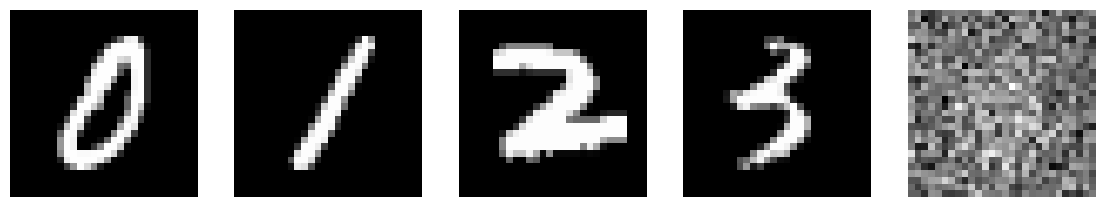

1/1 [==============================] - 0s 31ms/step


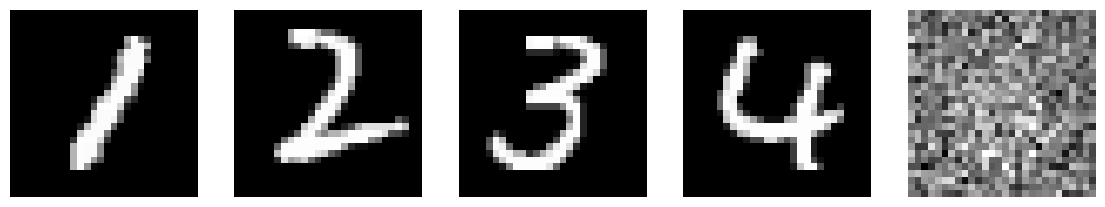

1/1 [==============================] - 0s 32ms/step


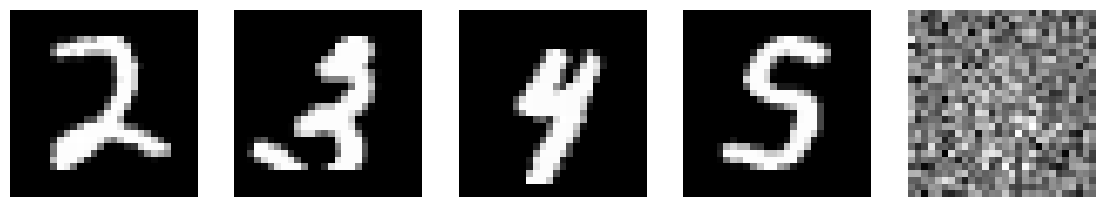

1/1 [==============================] - 0s 37ms/step


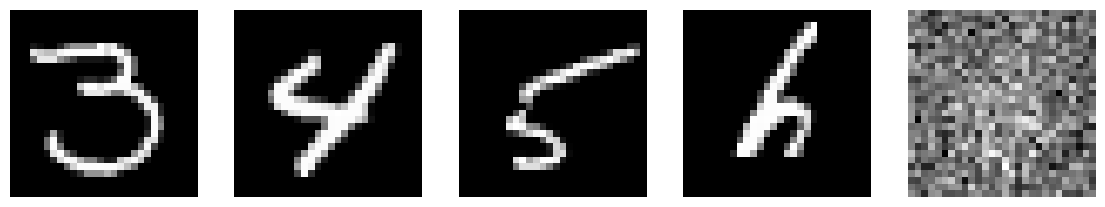

1/1 [==============================] - 0s 30ms/step


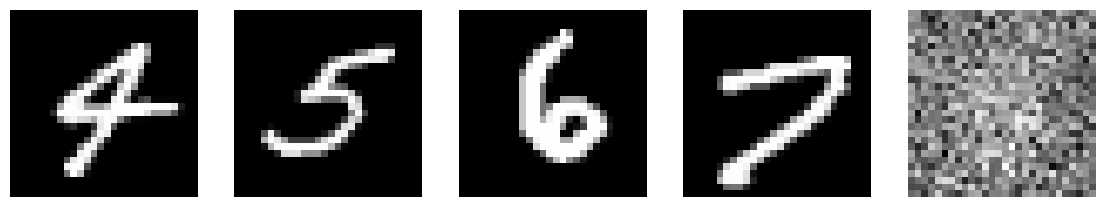

1/1 [==============================] - 0s 45ms/step


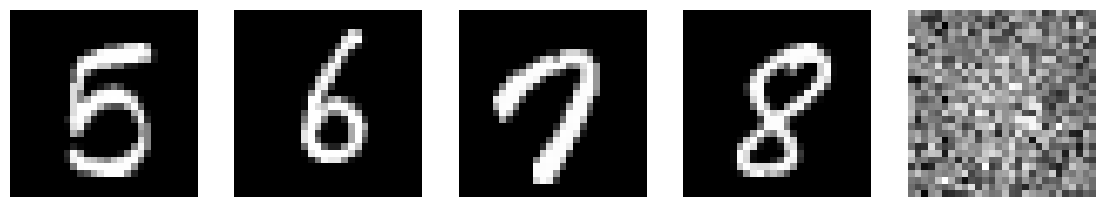

In [ ]:
# optimizer = SGD(Stochastic Gradient Descent)

for i in [0, 3, 30, 117, 125, 12]:
    img_generator(i)

1/1 [==============================] - 0s 440ms/step


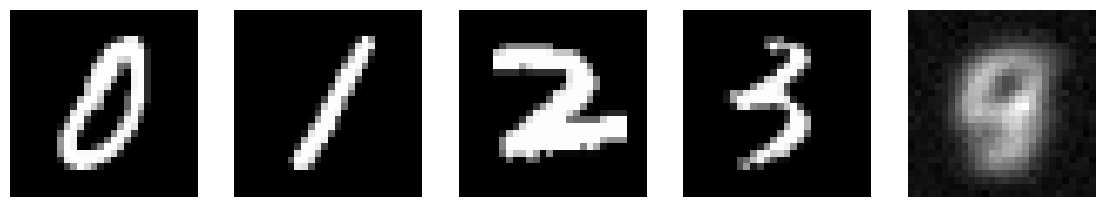

1/1 [==============================] - 0s 37ms/step


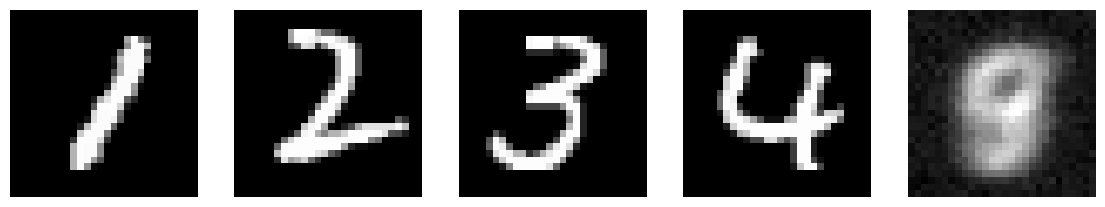

1/1 [==============================] - 0s 34ms/step


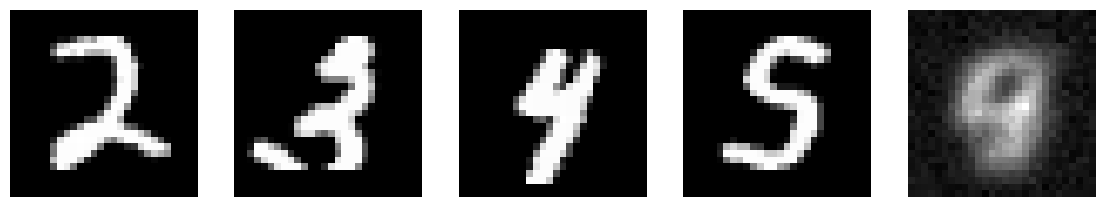

1/1 [==============================] - 0s 34ms/step


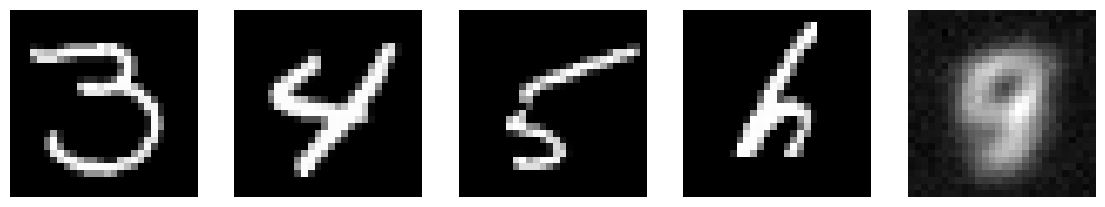

1/1 [==============================] - 0s 35ms/step


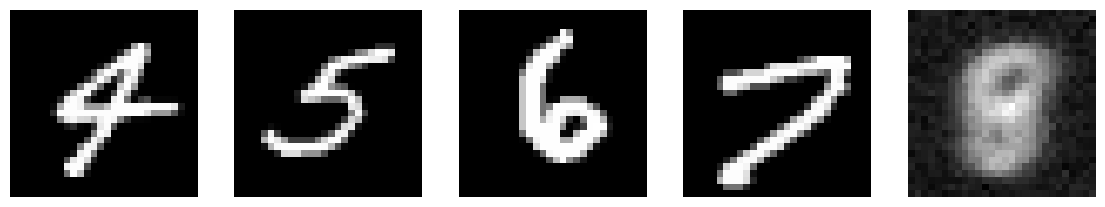

1/1 [==============================] - 0s 38ms/step


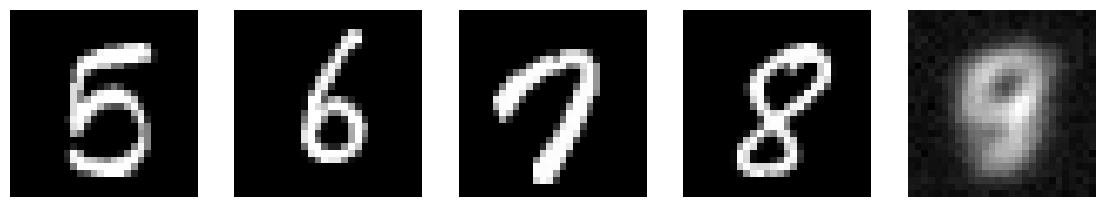

In [76]:
# optimizer = RMSPROP(Root Mean Squared Propagation)

for i in [0, 3, 30, 117, 125, 12]:
    img_generator(i)

1/1 [==============================] - 0s 419ms/step


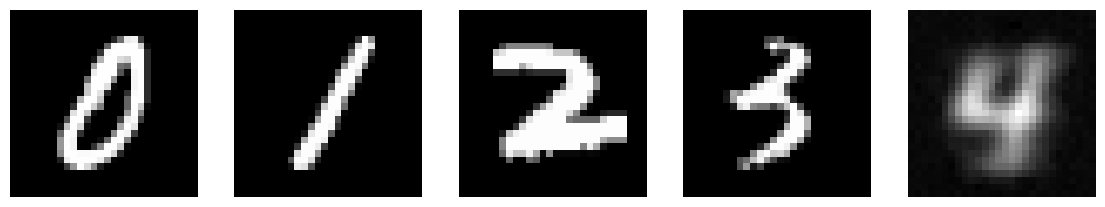

1/1 [==============================] - 0s 31ms/step


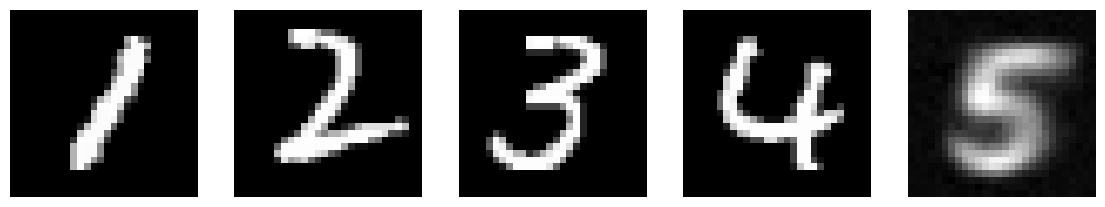

1/1 [==============================] - 0s 35ms/step


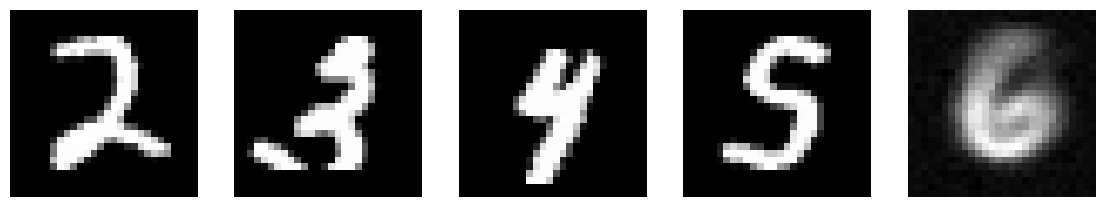

1/1 [==============================] - 0s 34ms/step


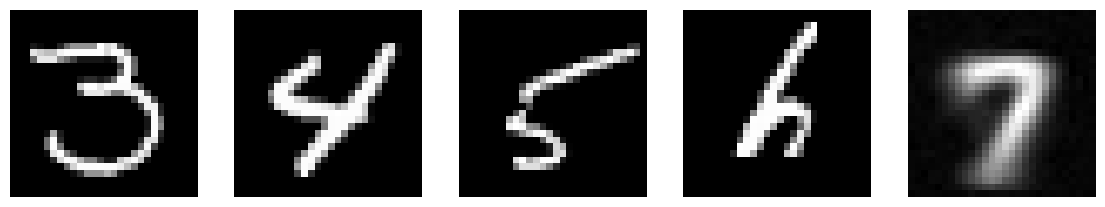

1/1 [==============================] - 0s 33ms/step


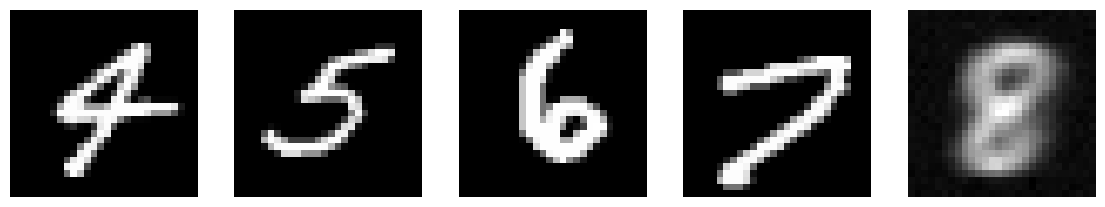

1/1 [==============================] - 0s 89ms/step


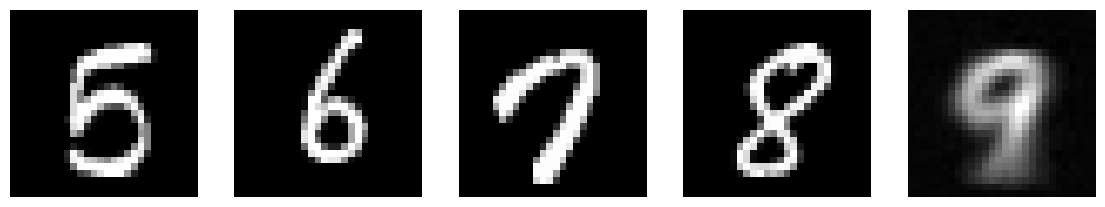

In [79]:
# optimizer = Adam

for i in [0, 3, 30, 117, 125, 12]:
    img_generator(i)